<a href="https://colab.research.google.com/github/plaban1981/Finetuning/blob/main/QLoRA_Fine_Tuning_SUPERVISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QLoRA Fine Tuning Notebook

Quantized Low-Rank Adapter Model Fine-tuning

---

This notebook is based on the original bitsandbytes notebook [here](https://colab.research.google.com/drive/1VoYNfYDKcKRQRor98Zbf2-9VQTtGJ24k).


In [ ]:
# Required when training models/data that are gated on HuggingFace, and required for pushing models to HuggingFace
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.0 MB/s eta 0:00:00


### Connect Google Drive

Optional but saves time by caching the model and allows for training data to be saved on Drive.

In [ ]:
# https://stackoverflow.com/questions/56081324/why-are-google-colab-shell-commands-not-working
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
cache_dir = "/content/drive/My Drive/huggingface_cache"
os.makedirs(cache_dir, exist_ok=True) # Ensure the directory exists

# Installation

In [ ]:
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U transformers
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00


# Load the Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# model_id = "meta-llama/Llama-2-7b-chat-hf"
# model_id = "meta-llama/Llama-2-7b-hf"
model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0},
    cache_dir=cache_dir)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### Prepare for LoRA fine-tuning

In [ ]:
# #UNCOMMENT ONLY if you want to load with adapters (it can be faster to download a base model and add adapters than to download a merged model)
# from peft import PeftModel

# adapter_model = "Trelis/Llama-2-13b-chat-hf-touch-rugby-rules-adapters"

# # load peft model with adapters
# model = PeftModel.from_pretrained(
#     model,
#     adapter_model,
# )

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig( #matching the Llama recipe
    r=8,
    lora_alpha=32,
    target_modules=[
              "self_attn.q_proj",
              "self_attn.k_proj",
              "self_attn.v_proj",
              "self_attn.o_proj",
              "self_attn.rotary_emb.inv_freq",
              "mlp.gate_proj",
              "mlp.up_proj",
              "mlp.down_proj",
              "input_layernorm.weight",
              "post_attention_layernorm.weight",
              "model.norm.weight",
              "lm_head.weight"
              ],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

ft_model = get_peft_model(model, config)
print_trainable_parameters(ft_model)

trainable params: 31293440 || all params: 6703272960 || trainable%: 0.46683821749069876


# Set up Tokenizer and Padding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id,use_fast=True)
print(tokenizer)

# Check if the pad token is already in the tokenizer vocabulary
if '<pad>' not in tokenizer.get_vocab():
  # Add the pad token
  tokenizer.add_special_tokens({"pad_token":"<pad>"})

# tokenizer.padding_side = 'left'
tokenizer.padding_side = 'right'

#Resize the embeddings
ft_model.resize_token_embeddings(len(tokenizer))

#Configure the pad token in the model
ft_model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert ft_model.config.pad_token_id == tokenizer.pad_token_id, "The model's pad token ID does not match the tokenizer's pad token ID!"

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', ft_model.config.pad_token_id)
print('Model config pad token ID:', ft_model.config.pad_token_id)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 32001. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


LlamaTokenizerFast(name_or_path='meta-llama/Llama-2-13b-chat-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False), 'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False)}, clean_up_tokenization_spaces=False)
Tokenizer pad token ID: 32000
Model pad token ID: 32000
Model config pad token ID: 32000


# Set up Evaluation

In [ ]:
from transformers import TextStreamer
from peft import PeftModel

system_prompt = 'You are a helpful assistant. You provide succinct answers.'

# Define a stream
def stream(user_prompt, model_type, adapter_model):

    if model_type == 'base':
        eval_model = model
    elif model_type == 'fine-tuned':
        eval_model = PeftModel.from_pretrained(
            model,
            adapter_model,
        )
    else:
        print('You must set the model_type to base or fine-tuned')
        exit()  # or raise an exception

    # print(f'Proceeding to inference with {model_type} model')

    eval_model.config.use_cache = True

    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

    # added_prompt = "In the context of Touch Rugby and the International Playing Rules set in 2020... "
    added_prompt = ''

    # Chat model prompt with system message
    prompt = f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{added_prompt}{user_prompt.strip()} {E_INST}\n\n"

    # # Without system message
    # prompt = f"{B_INST} {added_prompt}{user_prompt.strip()} {E_INST}\n\n"

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    streamer = TextStreamer(tokenizer)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=50, temperature=0.01)

def evaluation(model_type, adapter_model=''):
    questions = [
        "In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line?", #copied from the test data set to ensure training is working
        "How many players are on the field on each team in touch rugby?",
        "In touch rugby, does a forward pass result in a roll ball, a scrum, or something else?",
        "In touch rugby, how many metres must the defending team retreat after a touch?",
        "In touch rugby, how many substitutions are allowed during a game?",
        "In touch rugby, how long is half time?",
        "In touch rugby, how does the game commence?",
        "In touch rugby, how many metres must defenders retreat when there is a penalty? Is the same as after a touch is made?",
        "In touch rugby, how many touches is a team entitled to prior to a change in possession?",
        "In touch rugby, what happens if a player is touched by an opponent prior to making a pass?",
        "In touch rugby, how many points is a try worth?"
    ]

    answers = [
        "The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.",
        "6 players.",
        "Penalty.",
        "7 metres.",
        "There is no limit.",
        "5 minutes.",
        "The game begins with a tap on the halfway line.",
        "10 metres.",
        "Possession changes on the sixth (6th) touch.",
        "The defending team gains possession and takes a roll ball.",
        "1 point."
    ]

    # questions = [
    #     "1. Who is Ronan McGovern?"
    # ]

    # answers = [
    #     "Ronan McGovern is an Irish entrepreneur who lives in Dublin, Ireland."
    # ]

    for question, answer in zip(questions, answers):
        stream(question, model_type, adapter_model)
        print("Correct Answer:", answer)
        print('\n\n')

In [ ]:
evaluation("base")

<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line? [/INST]

The purpose of the Dead Ball Line in Touch Rugby International Playing Rules 2020 is to define the area
Correct Answer: The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

How many players are on the field on each team in touch rugby? [/INST]

In touch rugby, there are 7 players on the field for each team.</s>
Correct Answer: 6 players.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In touch rugby, does a forward pass result in a roll ball, a scrum, or something else? [/INST]

In touch rugby, a forward pass results in a scrum.</s>
Correct Answer: Penalty.



<s> [INST] <<SYS>>
You are a helpful as

#Load the Dataset

In [ ]:
## There is truncation to 1028, so don't unintentionally use datasets that are larger!

data_length = 180 #max sample length. This needs to be set to your longest train or test sample (plus some spare).

from datasets import load_dataset

data = load_dataset("Trelis/touch-rugby-rules")

In [ ]:
# Print first row of 'train' and 'test'
print("First row of train:", data['train'][11])
print("First row of test:", data['test'][0])

First row of train: {'prompt': 'In the context of Touch Rugby and the International Playing Rules set in 2020, what items of jewelry or accessories are players not allowed to wear?', 'completion': 'Players are not to participate in any match wearing any item of jewellery, chain, identification band/bracelet, or similar item that may prove dangerous. Any jewelry or other items that cannot be removed are to be taped to the satisfaction of the Referee.'}
First row of test: {'prompt': 'In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line?', 'completion': 'The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.'}


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

class TextDataset(Dataset):
    def __init__(self, encodings, response_lengths, input_lengths):
        self.encodings = encodings
        self.response_lengths = response_lengths
        self.input_lengths = input_lengths

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}

        # Set labels to be the same as input_ids
        item["labels"] = item["input_ids"].clone()

        # Calculate the start and end positions of the response
        response_start_position = self.input_lengths[idx]
        response_end_position = self.input_lengths[idx] + self.response_lengths[idx]

        # Create a loss mask that covers only the response tokens
        item["loss_mask"] = torch.zeros_like(item["input_ids"])
        item["loss_mask"][response_start_position:response_end_position] = 1

        # Shift the loss mask to the left by one position
        shifted_loss_mask = torch.cat([item["loss_mask"][1:], torch.tensor([0])])
        item["loss_mask"] = shifted_loss_mask

        # Shift the labels to the left by one position
        item["labels"][:-1] = item["input_ids"][1:]

        # Replace the token after the response with an EOS token
        item["labels"][response_end_position - 1] = 2

        # Replace the token after the response with an 1 in the loss mask
        item["loss_mask"][response_end_position - 1] = 1

        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [ ]:
def prepare_dataset(dataset, tokenizer):
    # Define the roles and markers
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
    B_INST, E_INST = "[INST]", "[/INST]"

    # Create the formatted text with the correct roles for each part of the dialogue
    formatted_dataset = dataset.map(
        lambda x: {
            "input_text": "".join([
                # f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{x['prompt'].strip()} {E_INST}\n\n"
                f"{B_INST} {x['prompt'].strip()} {E_INST}\n\n"
                f"{x['completion'].strip()}",  # appending the EOS token in TextData...
            ]),
            "response_text": "".join([
                f"{x['completion'].strip()}",  # appending the EOS token in TextData...
            ]),
        }
    )

    # Tokenize the datasets
    encodings = tokenizer([dialogue["input_text"] for dialogue in formatted_dataset], truncation=True, padding=True, max_length=data_length, return_tensors='pt', add_special_tokens=True)

    # Tokenize the response one by one without padding and special tokens for the purpose of calculating length
    response_lengths = [len(tokenizer.encode(dialogue["response_text"], truncation=True, max_length=data_length, padding=False, add_special_tokens=False)) for dialogue in formatted_dataset]

    # Tokenize the input one by one without padding and with the initial special token for the purpose of calculating length
    total_lengths = [len(tokenizer.encode(dialogue["input_text"], truncation=True, max_length=data_length, padding=False, add_special_tokens=True)) for dialogue in formatted_dataset]
    input_lengths = [total_length - response_length for total_length, response_length in zip(total_lengths, response_lengths)]

    # Create TextDataset
    text_dataset = TextDataset(encodings, response_lengths, input_lengths)

    return text_dataset

In [ ]:
# Apply function to your datasets
train_dataset = prepare_dataset(data['train'], tokenizer)
test_dataset = prepare_dataset(data['test'], tokenizer)

Map:   0%|          | 0/227 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### Examine the datasets

In [ ]:
# Print the number of items in the dataset
print(f"Number of samples in the dataset: {len(train_dataset)}")

# Get a sample item
# sample_item = train_dataset[2]  # replace 0 with the index of the sample you want to examine
sample_item = test_dataset[2]  # replace 0 with the index of the sample you want to examine

# Print the dimensions of the sample item
print(f"Dimensions of input_ids: {sample_item['input_ids'].shape}")
print(f"Dimensions of attention_mask: {sample_item['attention_mask'].shape}")
print(f"Dimensions of loss_mask: {sample_item['loss_mask'].shape}")
print(f"Dimensions of labels: {sample_item['labels'].shape}")

# Print some tokens from the start and end of the sample
num_tokens_to_print = 150 # replace with the number of tokens you want to print

print("\nTokens at the start of the sample:")
print(sample_item['input_ids'][:num_tokens_to_print].tolist())
print(tokenizer.convert_ids_to_tokens(sample_item['input_ids'][:num_tokens_to_print].tolist()))

print("\nLabels at the start of the sample:")
print(sample_item['labels'][:num_tokens_to_print].tolist())
print(tokenizer.convert_ids_to_tokens(sample_item['labels'][:num_tokens_to_print].tolist()))

print("Attention mask at the start of the sample:")
print(sample_item['attention_mask'][:num_tokens_to_print].tolist())

print("Loss mask at the start of the sample:")
print(sample_item['loss_mask'][:num_tokens_to_print].tolist())

print("\nTokens at the end of the sample:")
print(sample_item['input_ids'][-num_tokens_to_print:].tolist())
print(tokenizer.convert_ids_to_tokens(sample_item['input_ids'][-num_tokens_to_print:].tolist()))

print("\nLabels at the end of the sample:")
print(sample_item['labels'][-num_tokens_to_print:].tolist())
print(tokenizer.convert_ids_to_tokens(sample_item['labels'][-num_tokens_to_print:].tolist()))

print("Attention mask at the end of the sample:")
print(sample_item['attention_mask'][-num_tokens_to_print:].tolist())

print("Loss mask at the end of the sample:")
print(sample_item['loss_mask'][-num_tokens_to_print:].tolist())


Number of samples in the dataset: 227
Dimensions of input_ids: torch.Size([146])
Dimensions of attention_mask: torch.Size([146])
Dimensions of loss_mask: torch.Size([146])
Dimensions of labels: torch.Size([146])

Tokens at the start of the sample:
[1, 518, 25580, 29962, 512, 278, 3030, 310, 28675, 22647, 4623, 7412, 292, 390, 2540, 29871, 29906, 29900, 29906, 29900, 29892, 825, 338, 278, 6437, 310, 278, 25215, 8501, 1840, 29973, 518, 29914, 25580, 29962, 13, 13, 1576, 1840, 25215, 8501, 14637, 304, 278, 15130, 363, 278, 1661, 29899, 2696, 2548, 3815, 304, 11581, 29740, 29892, 28476, 936, 29892, 470, 26654, 23633, 1156, 385, 297, 1341, 292, 882, 29889, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 3200

#Train Llama 2!

## Set up and run Training (with saving of data logs to Drive)

In [ ]:
epochs = 3

In [ ]:
save_dir = cache_dir + f'/results/{model_id}_{epochs}_epochs_allModules_{data_length}_length_qa'
print(f'save_dir = {save_dir}')

save_dir = /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa


### Custom Supervised Trainer

In [ ]:
import torch.nn as nn

In [ ]:
import os
import transformers

# Custom callback to log metrics and save checkpoints
class LoggingCallback(transformers.TrainerCallback):
    def __init__(self, log_file_path, save_dir):
        self.log_file_path = log_file_path
        self.save_dir = save_dir

    def on_log(self, args, state, control, model=None, logs=None, **kwargs):
        with open(self.log_file_path, 'a') as f:
            if 'loss' in logs:
                f.write(f"Step: {state.global_step}, Training Loss: {logs['loss']}\n")
            if 'eval_loss' in logs:
                f.write(f"Step: {state.global_step}, Eval Loss: {logs['eval_loss']}\n")
            f.flush()  # Force flush the buffered data to file

        # # Save model checkpoint every 4 steps
        # if state.global_step % 4 == 0:
        #     print(f"Saving model checkpoint at step {state.global_step}")
        #     adapter_dir = self.save_dir + 'checkpoint_' + str(state.global_step)
        #     model.save_pretrained(adapter_dir)

# Log file path
log_file_path = os.path.join(cache_dir, "training_logs.txt")

# Create an instance of the custom callback
logging_callback = LoggingCallback(log_file_path, save_dir)

In [ ]:
class CustomTrainer(transformers.Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # Define the number of tokens you want to display
        num_tokens = 25  # This displays info on the actual and predicted tokens at the end of each sequence.

        labels = inputs.pop("labels")
        loss_mask = inputs.pop("loss_mask")

        # Forward pass
        outputs = model(**inputs)

        logits = outputs.logits

        # Check for NaN in logits and labels
        if torch.isnan(logits).any():
            print("NaN detected in logits")
            print(logits)

        # Convert logits to probabilities using softmax function
        probs = nn.functional.softmax(logits, dim=-1)

        # Get the most probable tokens
        predicted_token_ids = torch.argmax(probs, dim=-1)

        # Compute the loss
        loss_fct = nn.CrossEntropyLoss(reduction='none')
        losses = loss_fct(logits.view(-1, self.model.config.vocab_size), labels.view(-1))

        # Reshaping the losses to have dimensions [batch_size, seq_length]
        losses = losses.view(-1, inputs['input_ids'].size(1))

        # Apply the loss mask
        masked_loss = losses * loss_mask

        # Check for NaN in losses and zero in loss_mask.sum()
        if torch.isnan(losses).any():
            print("NaN detected in losses")
            # print(losses)

        if loss_mask.sum() == 0:
            print("Sum of loss_mask is zero")
            return (torch.tensor(0).to(loss_mask.device), outputs) if return_outputs else torch.tensor(0).to(loss_mask.device)  # Early return

        # Aggregate the masked losses
        loss = masked_loss.sum() / (loss_mask.sum() + 1e-9)  # normalizing by the number of tokens considered + epsilon to prevent division by zero

        # Print formatted tokens
        batch_size, seq_length = inputs['input_ids'].size()

        # num_tokens = len(inputs['input_ids'][0])

        # # Useful for debugging training - recommend just training a small number of steps
        # print("-" * 120)
        # print(f"Token analysis for last {num_tokens} tokens:")
        # header_format = "{:<10}{:<20}{:<20}{:<20}{:<20}{:<30}{:<30}".format("Index", "Input Token", "Predicted Token", "True Token", "Loss Mask", "Raw Loss", "Masked Loss")

        # for batch_idx in range(batch_size):
        #     input_tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][batch_idx])  # Using batch_idx
        #     predicted_tokens = tokenizer.convert_ids_to_tokens(predicted_token_ids[batch_idx])  # Using batch_idx
        #     true_tokens = tokenizer.convert_ids_to_tokens(labels[batch_idx])  # Using batch_idx

        #     print(f"\nBatch {batch_idx + 1} of {batch_size}:")
        #     print(header_format)
        #     for i in range(-num_tokens, 0, 1):
        #         index = seq_length + i  # Correct index based on sequence length
        #         print("{:<10}{:<20}{:<20}{:<20}{:<20.1f}{:<30.6f}{:<30.6f}".format(index, input_tokens[index], predicted_tokens[index], true_tokens[index], loss_mask[batch_idx, i].item(), losses[batch_idx, i], masked_loss[batch_idx, i]))
        #     print("-" * 120)

        return (loss, outputs) if return_outputs else loss

    def get_train_dataloader(self):
      train_dataset = self.train_dataset
      data_collator = self.data_collator

      dataloader_params = {
          "batch_size": self.args.train_batch_size,
          "collate_fn": data_collator,
          "num_workers": self.args.dataloader_num_workers,
          "pin_memory": self.args.dataloader_pin_memory,
      }

      if not isinstance(train_dataset, torch.utils.data.IterableDataset):
          dataloader_params["sampler"] = self._get_train_sampler()
          dataloader_params["drop_last"] = self.args.dataloader_drop_last

      return DataLoader(train_dataset, **dataloader_params)

    def get_eval_dataloader(self, eval_dataset=None):
      eval_dataset = eval_dataset if eval_dataset is not None else self.eval_dataset
      if eval_dataset is None:
          raise ValueError("Trainer: evaluation requires an eval_dataset.")

      data_collator = self.data_collator

      # Parameters for the DataLoader
      dataloader_params = {
          "batch_size": self.args.eval_batch_size,
          "collate_fn": data_collator,
          "num_workers": self.args.dataloader_num_workers,
          "pin_memory": self.args.dataloader_pin_memory,
      }

      # If your dataset isn't an instance of torch's IterableDataset, you can provide sampler and drop_last
      if not isinstance(eval_dataset, torch.utils.data.IterableDataset):
          dataloader_params["sampler"] = self._get_eval_sampler(eval_dataset)
          dataloader_params["drop_last"] = False  # Typically, you don't drop the last batch for evaluation

      return DataLoader(eval_dataset, **dataloader_params)

In [ ]:
class CustomDataCollator: # Needed if the EOS token is to be included in training.
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):

        input_ids = torch.stack([item['input_ids'] for item in batch])
        attention_mask = torch.stack([item['attention_mask'] for item in batch])
        labels = torch.stack([item['labels'] for item in batch])
        loss_mask = torch.stack([item['loss_mask'] for item in batch])

        # # Debugging: print details of the first sequence in the batch
        # num_elements_to_view = 20  # Number of last elements to view

        # # Decoding the input_ids
        # decoded_input_tokens = self.tokenizer.convert_ids_to_tokens(input_ids[0].tolist())

        # print("Debugging last", num_elements_to_view, "elements of the first sequence in the batch:")
        # print("{:<20}{:<20}{:<20}{:<20}".format("Token", "Input ID", "Label", "Loss Mask"))
        # for i in range(-num_elements_to_view, 0, 1):
        #   print("{:<20}{:<20}{:<20}{:<20}".format(decoded_input_tokens[i], input_ids[0, i].item(), labels[0, i].item(), loss_mask[0, i].item()))

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'loss_mask': loss_mask
        }

data_collator = CustomDataCollator(tokenizer)


In [ ]:
trainer = CustomTrainer(
    model=ft_model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, #turn on the eval dataset if you want to use evaluation functionality versus the test dataset (not provided in this script)
    args=transformers.TrainingArguments(
        num_train_epochs=epochs,
        per_device_train_batch_size=8, #use 8 for up to 256 context length on T4 for llama 13b
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=1,
        evaluation_strategy="steps",
        max_grad_norm=1,
        warmup_ratio=0.1,
        eval_steps=4,
        # max_steps=3,
        learning_rate=3e-5,
        fp16=True,
        logging_steps=1,
        output_dir=save_dir,
        optim="paged_adamw_8bit",
        # lr_scheduler_type='cosine',
        lr_scheduler_type='constant',
        save_steps=4, #not supported for 4-bit models
    ),
    data_collator=data_collator,
    callbacks=[logging_callback],
)
ft_model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [ ]:
trainer.train()
torch.cuda.empty_cache()

Step,Training Loss,Validation Loss
4,1.993200,1.846291
8,1.770800,1.650126
12,1.480000,1.529336
16,1.526800,1.471167
20,1.245100,1.444822
24,1.260900,1.428147
28,1.382900,1.399402
32,0.935200,1.364920
36,0.992900,1.331212
40,1.138200,1.307412


## Plotting

In [ ]:
!pip install matplotlib

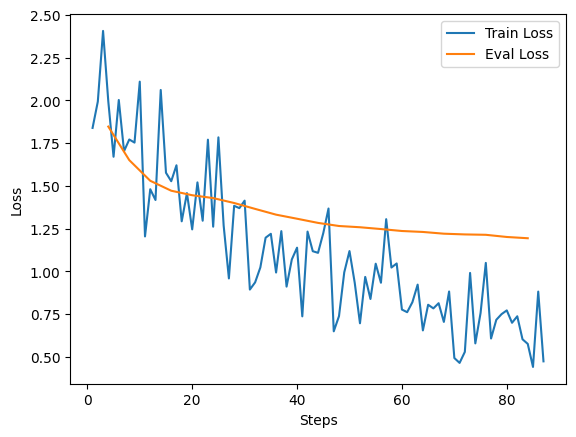

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

# Populate the lists from the log history
for entry in trainer.state.log_history:
    if 'loss' in entry:
        train_losses.append(entry['loss'])
        train_steps.append(entry['step'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_steps.append(entry['step'])

# Plot the losses
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate after Training

In [ ]:
adapter_dir = save_dir + '/checkpoint-20'
print(f'Running evaluation using the adapter at: {adapter_dir}\n\n')
evaluation("fine-tuned", adapter_dir)

Running evaluation using the adapter at: /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa/checkpoint-20


<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line? [/INST]

The Dead Ball Line is used to determine if a player is in a Dead Ball Area.</s>
Correct Answer: The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

How many players are on the field on each team in touch rugby? [/INST]

There are 7 players on the field for each team in touch rugby.</s>
Correct Answer: 6 players.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In touch rugby, does a forward pass result in a roll ball, a scrum, or 

In [ ]:
adapter_dir = save_dir + '/checkpoint-40'
print(f'Running evaluation using the adapter at: {adapter_dir}\n\n')
evaluation("fine-tuned", adapter_dir)

Running evaluation using the adapter at: /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa/checkpoint-40


<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line? [/INST]

The Dead Ball Line is the line that is 5 metres from the Try Line.</s>
Correct Answer: The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

How many players are on the field on each team in touch rugby? [/INST]

There are seven players on the field on each team in touch rugby.</s>
Correct Answer: 6 players.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In touch rugby, does a forward pass result in a roll ball, a scrum, or someth

In [ ]:
adapter_dir = save_dir + '/checkpoint-60'
print(f'Running evaluation using the adapter at: {adapter_dir}\n\n')
evaluation("fine-tuned", adapter_dir)

Running evaluation using the adapter at: /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa/checkpoint-60


<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line? [/INST]

The Dead Ball Line is the line that separates the Field of Play from the spectator area.</s>
Correct Answer: The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

How many players are on the field on each team in touch rugby? [/INST]

There are seven players on the field on each team in touch rugby.</s>
Correct Answer: 6 players.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In touch rugby, does a forward pass result in a roll ba

In [ ]:
adapter_dir = save_dir + '/checkpoint-84'
print(f'Running evaluation using the adapter at: {adapter_dir}\n\n')
evaluation("fine-tuned", adapter_dir)

Running evaluation using the adapter at: /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa/checkpoint-84


<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In the context of Touch Rugby International Playing Rules 2020, what is the purpose of the Dead Ball Line? [/INST]

The Dead Ball Line is the boundary between the Field of Play and the spectator area.</s>
Correct Answer: The Dead Ball Line marks the end boundaries of the field of play and indicates when the ball is out of play.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

How many players are on the field on each team in touch rugby? [/INST]

There are six players on the field on each team in touch rugby.</s>
Correct Answer: 6 players.



<s> [INST] <<SYS>>
You are a helpful assistant. You provide succinct answers.
<</SYS>>

In touch rugby, does a forward pass result in a roll ball, a 

# Push Adapters and Model to Hub

## Push Adapters to Hub

In [ ]:
# Select which checkpoint to push
adapter_to_push = save_dir + '/checkpoint-84'
print(f'Defining the parameters to push adapters for checkpoint: {adapter_dir}\n\n')

# Extract the last portion of the base_model
model_id = model_id.split("/")[-1]
fine_tuned_tag = 'touch-rugby-rules'

# Define the save and push paths
adapter_model_name = f"Trelis/{model_id}-{fine_tuned_tag}-adapters"
new_model = f"Trelis/{model_id}-{fine_tuned_tag}" #adjust 'Trelis' to your HuggingFace organisation

Defining the parameters to push adapters for checkpoint: /content/drive/My Drive/huggingface_cache/results/meta-llama/Llama-2-13b-chat-hf_3_epochs_allModules_180_length_qa/checkpoint-84




In [ ]:
# load peft model with the chosen adapter
model_to_push = PeftModel.from_pretrained(
    model,
    adapter_to_push,
)

In [ ]:
# Save the adapter model
model_to_push.save_pretrained(adapter_model_name, push_to_hub=True, use_auth_token=True)

# Push the model adapters to the hub
model_to_push.push_to_hub(adapter_model_name, use_auth_token=True)

/usr/local/lib/python3.10/dist-packages/transformers/utils/hub.py:844: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


adapter_model.bin:   0%|          | 0.00/125M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Trelis/Llama-2-13b-chat-hf-touch-rugby-rules-adapters/commit/e529e2e2ac91fc1cb0b1802eb761b4cae80843ee', commit_message='Upload model', commit_description='', oid='e529e2e2ac91fc1cb0b1802eb761b4cae80843ee', pr_url=None, pr_revision=None, pr_num=None)

## Merge Adapters and Push Full Model to Hub
We can't push the above model to hub because it has been prepared for 4-bit training and can't be pushed.

So, we need to re-load the model, merge the adapter and then push...

This is hard to do in a free colab notebook as you easily run out of RAM. It can be done if you have Colab Pro and use a high RAM environment and load the model to cpu. This works for Llama 7b and 13b.

For Llama 7b you can also restart the notebook and load the model as below (you'll need to install some packages from above) as the model should just about fit in RAM on the cpu.

btw, Llama 70b won't fit in even a 40 GB A100 colab notebook.

In [ ]:
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config=bnb_config,
#     device_map='cpu',
#     cache_dir=cache_dir)

In [ ]:
# # load peft model with the chosen adapter
# model_to_push = PeftModel.from_pretrained(
#     model,
#     adapter_to_push,
# )

In [ ]:
# model_to_push = model_to_push.merge_and_unload() # merge adapters with the base model.

In [ ]:
# model_to_push.push_to_hub(new_model, use_auth_token=True, max_shard_size="10GB", use_safetensors=True)

In [ ]:
# #Push the tokenizer
# from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# tokenizer.push_to_hub(new_model, use_auth_token=True)